# RAGを実装する

In [1]:
from collections import defaultdict
import io
import os
import pickle

from langchain_community.vectorstores.neo4j_vector import Neo4jVector
from langchain_ollama import OllamaEmbeddings, ChatOllama
from PIL import Image
from tqdm.notebook import tqdm

import settings as sets

## 定数定義

In [2]:
DATA_PAR_PATH = os.path.join('..','..','data')
INPUT_DATA_PATH = os.path.join(DATA_PAR_PATH,'output.pkl')

NEO4J_URI: str = sets.NEO4J_URI
NEO4J_USER: str = sets.NEO4J_USER
NEO4J_PASSWORD: str = sets.NEO4J_PASSWORD

MODEL_NAME = 'elyza:8b'
CHUNK_SIZE = 500

## Ollamaの準備
1. [Elyza-8B](https://huggingface.co/elyza/Llama-3-ELYZA-JP-8B-GGUF)をローカルにダウンロード
2. 以下の内容を`Modelfile`に書き込む
```
FROM [ダウンロードしたElyza-8Bのパス名]
TEMPLATE "{{ if .System }}<|start_header_id|>system<|end_header_id|>

{{ .System }}<|eot_id|>{{ end }}{{ if .Prompt }}<|start_header_id|>user<|end_header_id|>

{{ .Prompt }}<|eot_id|>{{ end }}<|start_header_id|>assistant<|end_header_id|>

{{ .Response }}<|eot_id|>"
PARAMETER stop <|start_header_id|>
PARAMETER stop <|end_header_id|>
PARAMETER stop <|eot_id|>
PARAMETER num_keep 24
```
3. `ollama create elyza:8b -f Modelfile`を実行
4. `ollama list` -> `elyza:8b`と表示さればOK

## データの読み込み

In [3]:
with open(INPUT_DATA_PATH, 'rb') as rf:
    elements = pickle.load(rf)

image


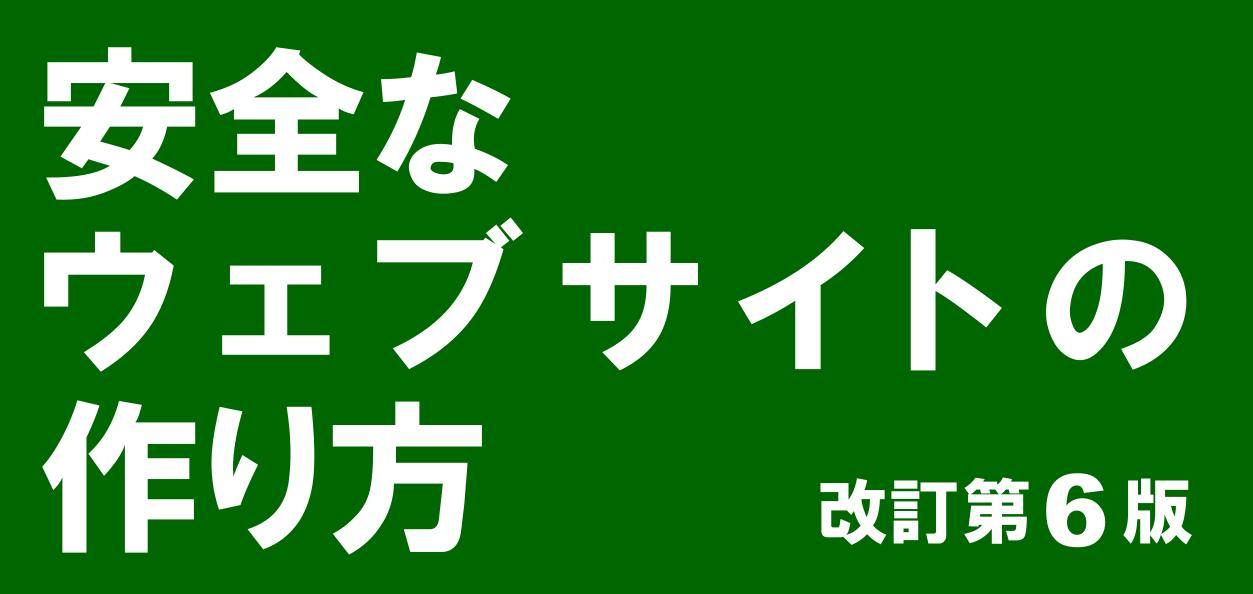

text
ウェブアプリケーションのセキュリティ実装とウェブサイトの安全性向上のための取り組み
image


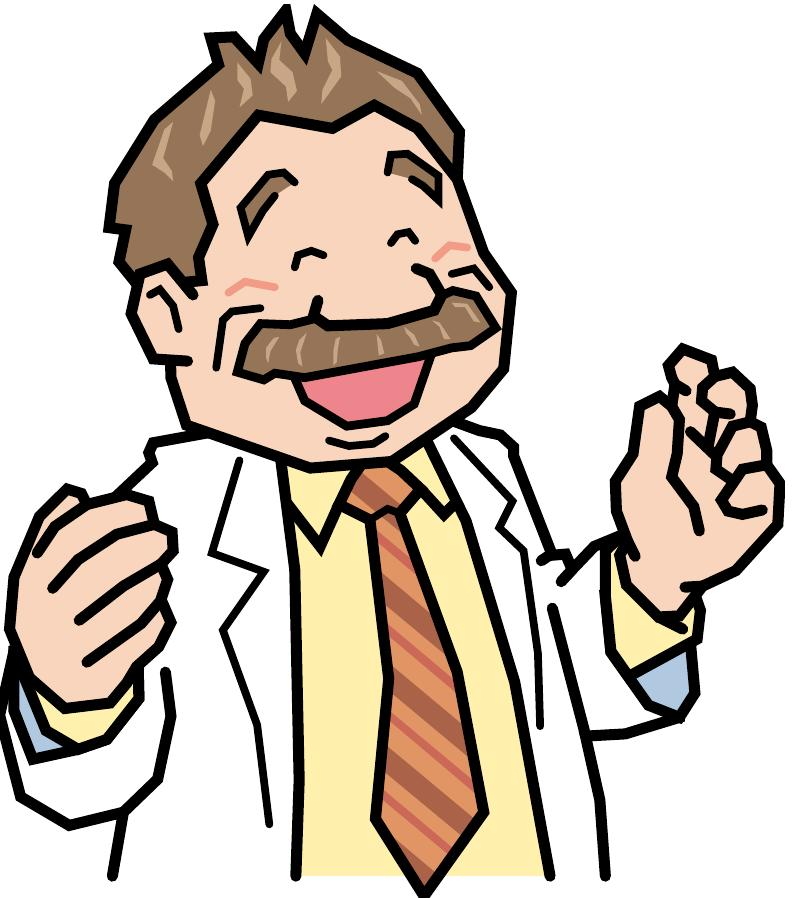

text
IDA独立行政法人情報処理推進機構セキュリティセンター
text
2012年12月


In [4]:
# データを確認してみる
page_no = 1
for elem in elements[page_no]:
    cat = elem['category']
    data = elem['data']
    print(cat)
    
    if cat == 'image':
        binary_image = io.BytesIO(data)
        image = Image.open(binary_image)
        display(image)
    else:
        print(data)

In [5]:
counter = defaultdict(int)

for page_no in range(len(elements)):
    for elem in elements[page_no]:
        cat = elem['category']
    
        if cat == 'text':
            detail_cat = elem['detail']
            counter[detail_cat] += 1

counter

defaultdict(int,
            {'Title': 507,
             'UncategorizedText': 116,
             'FigureCaption': 14,
             'NarrativeText': 628,
             'Header': 100,
             'Footer': 53,
             'ListItem': 118})

## Ollamaを使ってembeddingを実行する

In [6]:
embeddings = OllamaEmbeddings(model=MODEL_NAME)

In [7]:
total = len(elements.keys())
embed_info = []
text = ''
reference_text = ''

def add_embed_info(text):
    text = text.rstrip('\n')
    embed_text = embeddings.embed_query(text)  # str -> vector(dim=4096)
    embed_info.append(
        {
            'text': text,
            'reference_text': reference_text,
            'embedding': embed_text
        }
    )

for page_no in tqdm(elements.keys(), total=total):    
    for elem in elements[page_no]:
        cat = elem['category']
        data = elem['data']
        
        if cat == 'text':
            detail_cat = elem['detail']
            
            if detail_cat == 'Header':
                if len(text) == 0:
                    continue
                
                add_embed_info(text)
                
                text = data
                reference_text = data
            elif len(text) < CHUNK_SIZE:
                text += data + '\n'
            else:
                add_embed_info(text)
                
                text = data

if len(text) > 0:
    add_embed_info(text)

  0%|          | 0/107 [00:00<?, ?it/s]

In [8]:
# データの確認
embed_info[1]

{'text': 'はじめにはじめに\nインターネットでは、多くのウェブサイトがそれぞれサービスを提供しています。通信利用動向調査「によると、2012年現在、日本におけるインターネットの利用者数は9.600万人を超えると推定され、ウェブを通じた情報のやり取りは今後も増え続けることが予想されます。\n一方、ウェブサイトの「安全上の欠陥」(脆弱性)が狙われる事件も後を絶ちあません。最近は営利目的の犯行も目立ち、悪質化が進む傾向にあります。独立行政法人情報処理推進機構(iPA)が届出*を受けたウェブサイトの脆弱性関連情報は、届出受付開始から.累計で7.950件となりました。中でも「SQLインジェクション」と呼ばれる脆弱性は、ウェブサイトから個人情報を不正に盗まれたり、ウェブページにウイルスを埋め込まれたりするといった事件における原因のーーつと考えられています。\nウェブサイトの安全を維持するためには、ウェブサイトを構成する要素に対して、それぞれに適した対策を実施する必要があります。たとえば、サーバOSやソフトウェアに対しては、各ベンダが提供する情報を元に、脆弱性修正パッチの適用や安全な設定等、共通した対応を実施することができます。しかし、「ウェブアプリケーション」については、それぞれのウェブサイトで独自に開発する場合が多く、セキュリテイィ対策はそれぞれのウェブアプリケーションに対して個別に実施する必要があります。すでに運用を開始しているウェブアプリケーションにセキュリティ上の問題が発覚した場合、設計レベルから修正することは難しい場合が少なくなく、場あたり的な対策で済まさざるをえないこともあります。対策は可能な限り、根本的な解決策を開発段階で実装することが望まれます。',
 'reference_text': 'はじめに',
 'embedding': [-0.005483301,
  -0.020004254,
  -0.009564777,
  -0.008672884,
  -0.006598138,
  0.015458615,
  -0.010121352,
  -0.0020423727,
  -0.022983061,
  -0.008214118,
  -0.0022461975,
  -0.0010792646,
  -0.020254053,
  -0.

## Neo4jへアップロード

In [9]:
%%time

text_embeddings = [(e['text'], e['embedding']) for e in embed_info]
metadatas = [{'reference_text': e['reference_text']} for e in embed_info]

graph_db = Neo4jVector.from_embeddings(
    text_embeddings=text_embeddings,
    embedding=embeddings,
    metadatas=metadatas,
    url=NEO4J_URI,
    username=NEO4J_USER,
    password=NEO4J_PASSWORD
)

CPU times: user 1.61 s, sys: 170 ms, total: 1.78 s
Wall time: 9.29 s


## グラフDBを用いたRAGを実装（リレーションあり）
リレーションには、ファイルのヘッダーテキストを使用する。  
ヘッダーテキストは以下がある（空白に関しては初期状態なので大目に..）

In [10]:
headers = set([e['reference_text'] for e in embed_info])
headers

{'',
 '1.1SQLインジェクション',
 '1.2OSコマンド・インジェクション',
 '1.3パス名パラメータの未チェック/ディレクトリラバーサル',
 '1.4セッション管理の不備',
 '1.5クロスサイト・スクリプティング',
 '1.6CSRF',
 '1.7HTTPヘッダ・インジェクション',
 '1.8メールヘッダ・インジェクション',
 '1.9アクセス制御や認可制御の欠落',
 '2.1ウェブサーバのセキュリティ対策',
 '2.2DNS情報の設定不備',
 '2.3ネットワーク盗聴への対策',
 '2.5フィッシング詐欺を助長しないための対策',
 '2.6WAFによるウェブアプリケーションの保護',
 '2.7携帯ウェブ向けのサイトにおける注意点',
 '3.1失敗例(SQLインジェクション)',
 '3.2失敗例(OSコマンド・インジェクション)',
 '3.3失敗例(パス名パラメータの未チェック)',
 '3.4失敗例(不適切なセッション管理)',
 '3.5失敗例(クロスサイト・スクリプティング)',
 '3.6失敗例(CSRF)',
 '3.7失敗例(HTTPヘッダ・インジェクション',
 '3.7失敗例(HTTPヘッダ・インジェクション)',
 '3.8失敗例(メールヘッダ・インジェクション)',
 'CWE対応表',
 'おわりに',
 'はじめに',
 'チェックリスト',
 '参考資料',
 '用語集'}

`トピック`ノードを作成する

In [11]:
create_node_query = 'CREATE' + '\n'

for header in headers:
    query_elem = f"(:Topic {{topic: '{header}'}}),"
    
    create_node_query += query_elem + '\n'

create_node_query = create_node_query.rstrip(',\n')
print(create_node_query)

CREATE
(:Topic {topic: ''}),
(:Topic {topic: '1.1SQLインジェクション'}),
(:Topic {topic: '1.4セッション管理の不備'}),
(:Topic {topic: '3.2失敗例(OSコマンド・インジェクション)'}),
(:Topic {topic: '3.7失敗例(HTTPヘッダ・インジェクション'}),
(:Topic {topic: '参考資料'}),
(:Topic {topic: '用語集'}),
(:Topic {topic: '3.7失敗例(HTTPヘッダ・インジェクション)'}),
(:Topic {topic: '2.5フィッシング詐欺を助長しないための対策'}),
(:Topic {topic: '1.5クロスサイト・スクリプティング'}),
(:Topic {topic: '1.7HTTPヘッダ・インジェクション'}),
(:Topic {topic: '3.8失敗例(メールヘッダ・インジェクション)'}),
(:Topic {topic: 'CWE対応表'}),
(:Topic {topic: '1.6CSRF'}),
(:Topic {topic: '2.2DNS情報の設定不備'}),
(:Topic {topic: '1.9アクセス制御や認可制御の欠落'}),
(:Topic {topic: 'おわりに'}),
(:Topic {topic: '3.1失敗例(SQLインジェクション)'}),
(:Topic {topic: '3.6失敗例(CSRF)'}),
(:Topic {topic: '2.7携帯ウェブ向けのサイトにおける注意点'}),
(:Topic {topic: '2.1ウェブサーバのセキュリティ対策'}),
(:Topic {topic: '3.3失敗例(パス名パラメータの未チェック)'}),
(:Topic {topic: '1.3パス名パラメータの未チェック/ディレクトリラバーサル'}),
(:Topic {topic: '3.4失敗例(不適切なセッション管理)'}),
(:Topic {topic: '2.3ネットワーク盗聴への対策'}),
(:Topic {topic: 'はじめに'}),
(:Topic {topic: '3.5失敗例(クロスサイ

In [12]:
%%time

graph_db.query(create_node_query)

CPU times: user 7.32 ms, sys: 4.45 ms, total: 11.8 ms
Wall time: 501 ms


[]

追加した`トピック`ノードに対して、関連するテキスト情報（embedding情報なども含めて）とのリレーションを張る

In [13]:
create_relation_query = '''
MATCH (c:Chunk), (t:Topic)
WHERE c.reference_text = t.topic
CREATE (t)-[:reference]->(c)'''

In [14]:
%%time

graph_db.query(create_relation_query)

CPU times: user 8.37 ms, sys: 6.6 ms, total: 15 ms
Wall time: 338 ms


[]